In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import latools as la

from comparison_tools import helpers, stats_zircon, plots_zircon

import matplotlib.pyplot as plt
%matplotlib inline

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


In [2]:
dataformat = {'genfromtext_args': {'delimiter': ',',
                                   'skip_header': 4,
                                   'skip_footer': 3},
              'column_id': {'name_row': 3,
                            'delimiter': ',',
                            'timecolumn': 0,
                            'pattern': '([A-z]{1,2}[0-9]{1,3})'},
              'meta_regex': {2: (['date', 'method'],
                                 '([0-9/]+ [0-9:]+ [AMP]+) using (.*?),')}
             }

## Load Data

In [3]:
dat = la.analyse('raw_data/zircon/', dataformat=dataformat, srm_identifier='NIST', internal_standard='Si29')

latools analysis using "DEFAULT" configuration:
  34 Data Files Loaded: 6 standards, 28 samples
  Analytes: Li7 Mg24 Al27 Si29 P31 Ca43 Ti49 Y89 La139 Ce140 Pr141 Nd146 Sm147 Eu153 Gd157 Tb159 Dy163 Ho165 Er166 Tm169 Yb172 Lu175 Hf177 Pb206 Th232 U238
  Internal Standard: Si29


In [4]:
dat.basic_processing(autorange_on_mult=(1.5, 1), autorange_off_mult=(1., 3.),
                     bkg_weight_fwhm=800.,
                     calib_srms_used='NIST610', calib_drift_correct=True,
                     plots=False)

Applying Calibrations: 100%|██████████| 34/34 [00:01<00:00, 22.59it/s]


# Filtering

### Sample Info:
Zircon Si wt%: ~16

Contaminant Indicators:
 - Ca
 - La (< 320 ppb) 
 - Ti (< 12 ppm)
 - Mg
 - Al

In [5]:
dat.analytes

array(['Li7', 'Mg24', 'Al27', 'Si29', 'P31', 'Ca43', 'Ti49', 'Y89',
       'La139', 'Ce140', 'Pr141', 'Nd146', 'Sm147', 'Eu153', 'Gd157',
       'Tb159', 'Dy163', 'Ho165', 'Er166', 'Tm169', 'Yb172', 'Lu175',
       'Hf177', 'Pb206', 'Th232', 'U238'],
      dtype='<U5')

In [6]:
contam = ['La139', 'Ti49', 'Mg24', 'Al27']
interest = ['Pb206', 'Hf177', 'Nd146']

## Data Overview

Drawing Plots: 100%|██████████| 21/21 [00:00<00:00, 106.96it/s]


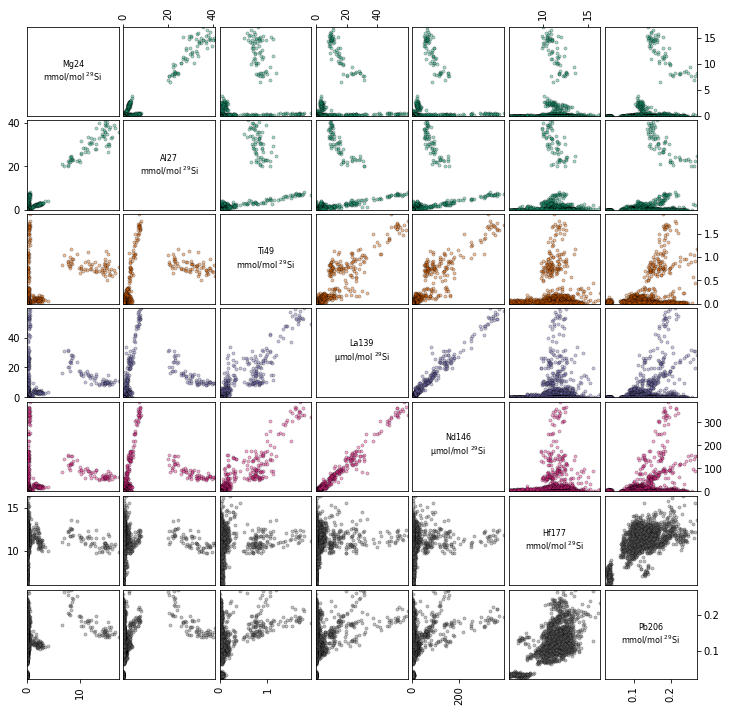

In [7]:
fig, axs = dat.crossplot(contam + interest, mode='scatter', filt=False)

### Thresholds

In [8]:
from latools.helpers.chemistry import to_molar_ratio

In [9]:
# calculate molar ratio thresholds
La_thresh = to_molar_ratio(320e-9, 16e-2, 138.9, 28.09) * 10
Ti_thresh = to_molar_ratio(12e-6, 16e-2, 47.9, 28.09) * 5

In [10]:
dat.filter_clear()
dat.filter_threshold('La139', La_thresh)

Threshold Filter: 100%|██████████| 28/28 [00:00<00:00, 9278.70it/s]


In [11]:
# dat.filter_clear()
dat.filter_threshold('Ti49', Ti_thresh)

Threshold Filter: 100%|██████████| 28/28 [00:00<00:00, 15319.66it/s]


In [12]:
dat.filter_on('Ti49_thresh_below', show_status=False)
dat.filter_on('La139_thresh_below', show_status=True)

Subset: All Samples

n  Filter Name           Li7    Mg24   Al27   Si29   P31    Ca43   Ti49   Y89    La139  Ce140  Pr141  Nd146  Sm147  Eu153  Gd157  Tb159  Dy163  Ho165  Er166  Tm169  Yb172  Lu175  Hf177  Pb206  Th232  U238   
0  La139_thresh_below    True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   
1  La139_thresh_above    False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  
2  Ti49_thresh_below     True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   True   
3  Ti49_thresh_above     False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  Fal

In [13]:
_ = dat.filter_nremoved()

Sample     tot flt %rm 
117          65  25  62
119          62  52  16
120          64  51  20
121          63  43  32
126          67   0 100
Temora-5     67  67   0
127          65  65   0
128          65  65   0
131          66  66   0
134          66  58  12
135          66  66   0
Temora-6     66  66   0
139          66  61   8
140          68  68   0
141          64  64   0
143          66  54  18
144          64  57  11
146          64  56  12
147          65  65   0
148          67  67   0
149          67  15  78
150          66  59  11
151          64  64   0
152          63  63   0
153          66  61   8
154          66  65   2
155          64  64   0
157          64  64   0


Drawing Plots: 100%|██████████| 21/21 [00:00<00:00, 117.04it/s]


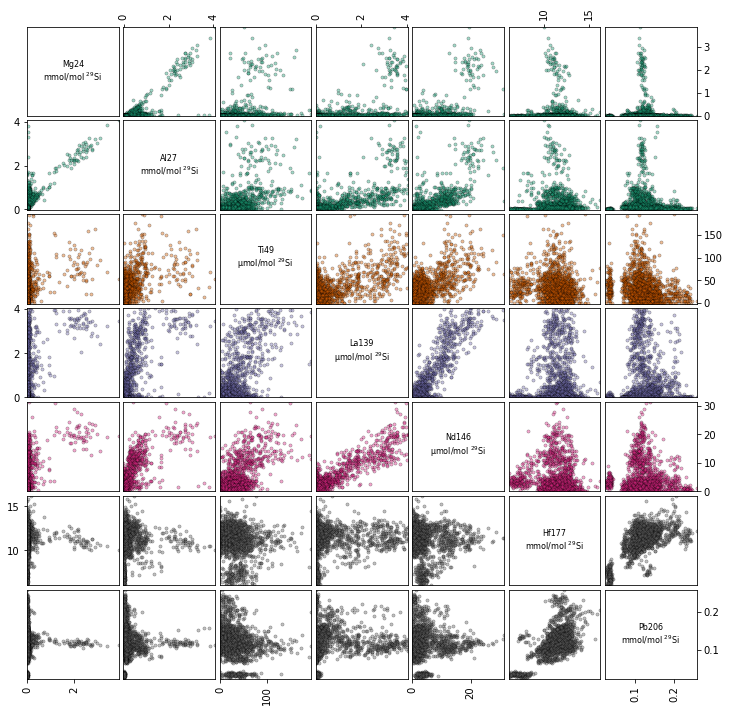

In [14]:
fig, axs = dat.crossplot(contam + interest, mode='scatter', filt=True)

### 'Filter Defragmentation'

In [15]:
dat.filter_defragment(4, 'exclude')

In [16]:
dat.filter_off()
dat.filter_on('defrag')

## Signal Optimisation

In [17]:
dat.optimise_signal(['Ti49', 'La139', 'Al27'], threshold_mode='kde_first_max', x_bias=0.2)

Optimising: 100%|██████████| 28/28 [00:02<00:00, 13.78it/s]


A Few Problems:
126_1: Optmisation failed. No contiguous data regions longer than 5 points.

  *** Check Optimisation Plots ***


In [18]:
dat.optimisation_plots(filt=True)

Drawing Plots: 100%|██████████| 28/28 [00:14<00:00,  1.89it/s]


In [19]:
dat.filter_off()
dat.filter_on('optim', show_status=True)

Subset: All Samples

n  Filter Name                 Li7    Mg24   Al27   Si29   P31    Ca43   Ti49   Y89    La139  Ce140  Pr141  Nd146  Sm147  Eu153  Gd157  Tb159  Dy163  Ho165  Er166  Tm169  Yb172  Lu175  Hf177  Pb206  Th232  U238   
0  La139_thresh_below          False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  
1  La139_thresh_above          False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  
2  Ti49_thresh_below           False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  
3  Ti49_thresh_above           False  False  False  False  False  False  False  False  False  False  False  False  False  F

## Be conservative: Filter Trimming

In [20]:
# trim filter edges, to be conservative
dat.filter_trim(start=1, end=1)

In [21]:
dat.filter_off()
dat.filter_on('trim')

## Effect of all filtering

Drawing Plots: 100%|██████████| 6/6 [00:00<00:00, 131.14it/s]


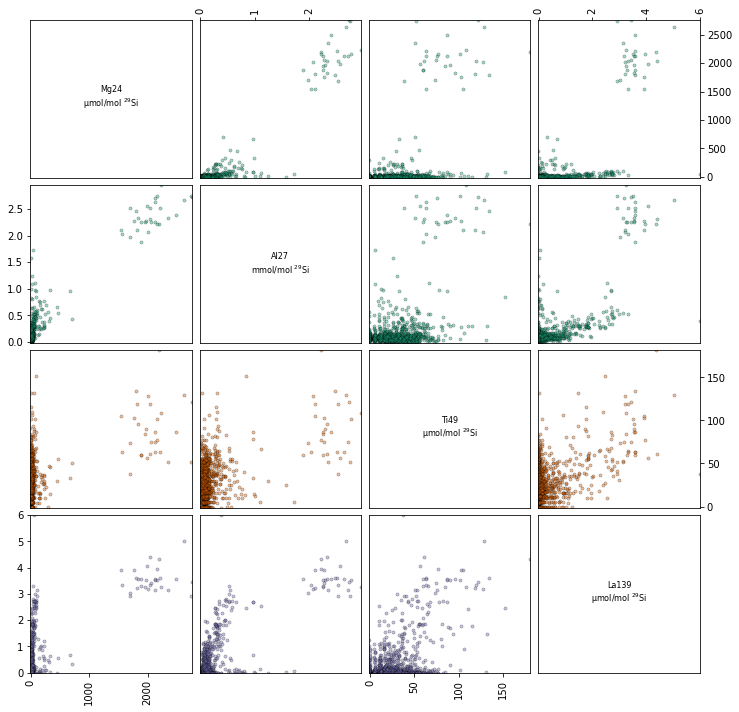

In [22]:
fig, axs = dat.crossplot(contam, mode='scatter', filt=True)

In [23]:
# f, a = dat.gradient_crossplot(contam, mode='scatter', win=5, filt=True)

# Comparison to Reference Data

In [24]:
import re

import numpy as np
import pandas as pd

from latools.helpers.chemistry import elements, calc_M, to_mass_fraction

### Load Reference Data

In [25]:
rd = helpers.load_reference_data('zircon_reference')

In [26]:
rd.index = rd.index.droplevel('rep')

### Get LAtools Stats

In [27]:
# 'H15' stats are Huber 'robust' statistics, which recursively remove outliers
dat.sample_stats(stats=['H15_mean', 'H15_se'])

Calculating Stats: 100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


In [28]:
las = dat.getstats()

In [29]:
# remove 'replicate' from index
las.index = las.index.droplevel('rep')

In [30]:
# convert lead 206 to total lead
els = elements().set_index('isotope')

las.loc[:,'Pb206'] /= (100 / els.loc[206, 'percent'])

### Convert Molar Ratio data to ppm

In [31]:
# rename columns to element names
ename = re.compile('[A-z]+')
las.columns = [ename.match(c).group() for c in las.columns]

In [32]:
# load mass list
els = elements(all_isotopes=False)

In [33]:
els['Si']

28.085412842617771

In [34]:
# calculate wt% Si from wt% SiO2
rd.loc[:, 'wtpcSi'] = rd.loc[:, 'SiO2'] * els['Si'] / calc_M('SiO2')

In [35]:
# transfer wt% Si to latools data
la_ppm = las.join(rd.loc[:, 'wtpcSi'], how='inner')

In [36]:
# calculate mass fractions
for c in las.columns:
    la_ppm.loc[:, c] = to_mass_fraction(las.loc[:, c], la_ppm.loc[:, 'wtpcSi'] * 1e-2, 
                                        els[ename.match(c).group()], els['Si'])

In [37]:
# convert Al to wt% Al2
la_ppm.loc[:, 'Al'] *= (2 * 1e-4)

In [38]:
# isolate means
lad = la_ppm.loc['H15_mean',:].join(la_ppm.loc['H15_se', :], rsuffix='_err') * 1e6  # convert to ppm

In [40]:
# combine data
comp = lad.join(rd, lsuffix='_la', rsuffix='_rd')

## Comparison Plots

In [41]:
from comparison_tools.plots import get_panel_bounds

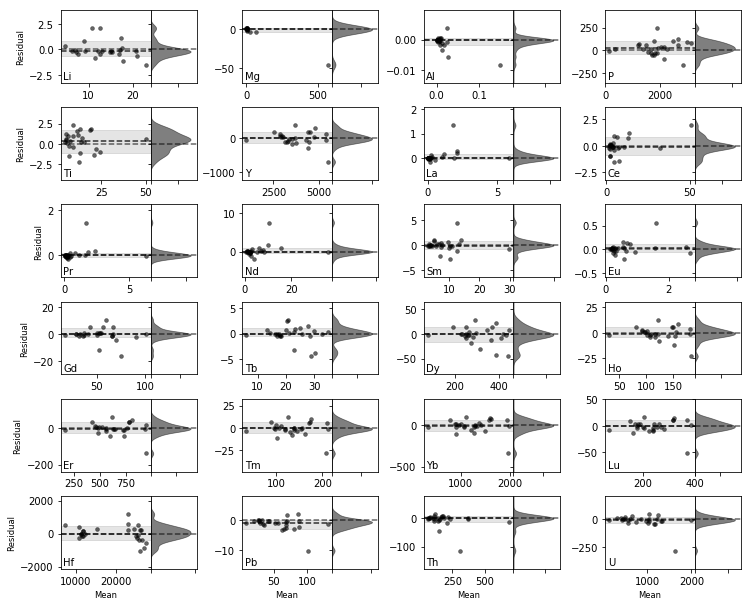

In [42]:
fig, axs = plots_zircon.bland_altman_plots(comp)

In [43]:
fig.savefig('Figures/zircon_comparison.pdf')
fig.savefig('Figures/zircon_comparison.png', dpi=200)

In [44]:
stat = stats_zircon.comparison_stats(comp)

In [45]:
stat.to_csv('Stats/zircon_stats.csv')